In [1]:
# Import libraries
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # data visualization
from matplotlib import pyplot as plt

In [2]:
# Get the medal details dataset
df_medal_details = pd.read_csv('../data/etl/medals_by_season_country_discip_event_type.csv')
df_medal_details.head()

,game_season,country_code,country_name,discipline_title,event_title,event_gender,medal_type,medal_count
0,Summer,AFG,Afghanistan,Taekwondo,58 - 68 kg men,Men,BRONZE,1
1,Summer,AFG,Afghanistan,Taekwondo,beijing 2008 taekwondo - 58 kg men,Men,BRONZE,1
2,Summer,AHO,Netherlands Antilles,Sailing,division ii - windsurfer men,Open,SILVER,1
3,Summer,ALG,Algeria,Athletics,1500m men,Men,GOLD,2
4,Summer,ALG,Algeria,Athletics,1500m men,Men,SILVER,1


In [3]:
# Get all of the other datasets in the etl folder
df_hapiness = pd.read_csv('../data/etl/happiness_avg_by_country.csv')
df_gdp = pd.read_csv('../data/etl/gdp_avg_by_country.csv')
df_nutrition = pd.read_csv('../data/etl/nutrition_2017_by_country.csv')
df_nutrition.head()


,country_code,country_name,calories_pct,nutrients_pct,good_diet_pct,bad_diet_pct,calories_mills,nutrients_mills,diet_mills,population
0,ABW,Aruba,NaN,NaN,NaN,NaN,NaN,NaN,NaN,105.361
1,AGO,Angola,57.2,87.1,7.1,92.9,17.0,26.0,27.7,29816.769
2,AIA,Anguilla,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ALB,Albania,0.0,13.0,62.2,37.8,0.0,0.4,1.1,2873.457
4,ARE,United Arab Emirates,0.0,0.0,NaN,0.0,0.0,0.0,0.0,9487.206


In [4]:
# Unwanted columns - Simplify the dataset
unwanted_cols = [
    'support',
    'health',
    'freedom',
    'generosity',
    'corruption',
    'positivity',
    'negativity',
    'calories_pct',
    'nutrients_pct',
    'calories_mills',
    'nutrients_mills',
    'diet_mills'
]

In [5]:
# Function to merge medals with happiness, GDP and nutrition datasets
def merge_hap_gdp_nut(df_medal_slice: pd.DataFrame) -> pd.DataFrame:
    df_merged = pd.merge(df_medal_slice, df_hapiness, on='country_name', how='left')
    df_merged = pd.merge(df_merged, df_gdp, on='country_name', how='left')
    df_merged = pd.merge(df_merged, df_nutrition, on='country_name', how='left')
    df_merged = df_merged.drop(columns=['country_code']).reset_index(drop=True)
    df_merged.drop(unwanted_cols, axis=1, inplace=True)
    return df_merged

In [6]:
# Function to slice the medal details dataset and prepare it for correlation
def slice_medal_details_data(data_to_select: dict[str, str]) -> pd.DataFrame:
    drop_medal_cols = ['game_season', 'country_code', 'discipline_title', 'event_title', 'event_gender', 'medal_type']
    group_medal_cols = ['country_name']

    df_slice = df_medal_details.copy()
    for key, value in data_to_select.items():
        df_slice = df_slice[df_slice[key] == value]

    df_slice = df_slice.drop(columns=drop_medal_cols)
    df_slice = df_slice.groupby(group_medal_cols)['medal_count'].sum().reset_index()
    return df_slice.reset_index(drop=True)

In [7]:
def box_plot_medals(df: pd.DataFrame, title: str) -> None:
    medals = df['medal_count']
    fig1, ax1 = plt.subplots()
    ax1.set_title(title)
    ax1.set_ylabel('Medal Count')
    ax1.boxplot(medals)
    plt.show()

In [8]:
# Women's summer games correlation
data_to_select = {
    'game_season': 'Summer', 
    'event_gender': 'Women'
}
df = slice_medal_details_data(data_to_select)
df = merge_hap_gdp_nut(df)
df.info()
df.set_index('country_name').corr()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   country_name   103 non-null    object 
 1   medal_count    103 non-null    int64  
 2   happiness      85 non-null     float64
 3   wealth         84 non-null     float64
 4   gdp_avg        84 non-null     float64
 5   good_diet_pct  69 non-null     float64
 6   bad_diet_pct   72 non-null     float64
 7   population     76 non-null     float64
dtypes: float64(6), int64(1), object(1)
memory usage: 6.6+ KB


,medal_count,happiness,wealth,gdp_avg,good_diet_pct,bad_diet_pct,population
medal_count,1.000000,0.234169,0.292613,0.831738,0.287825,-0.269807,0.313934
happiness,0.234169,1.000000,0.802930,0.208903,0.745038,-0.729592,-0.178541
wealth,0.292613,0.802930,1.000000,0.228058,0.897316,-0.890775,-0.159272
gdp_avg,0.831738,0.208903,0.228058,1.000000,0.210865,-0.197154,0.409605
good_diet_pct,0.287825,0.745038,0.897316,0.210865,1.000000,-1.000000,-0.151061
bad_diet_pct,-0.269807,-0.729592,-0.890775,-0.197154,-1.000000,1.000000,0.159740
population,0.313934,-0.178541,-0.159272,0.409605,-0.151061,0.159740,1.000000


In [9]:
# Top and Bottom Womens Summer Games
df.reset_index(drop=True, inplace=True)
df = df.sort_values(by='medal_count', ascending=False).reset_index(drop=True)
display(df.head())
display(df.tail())

,country_name,medal_count,happiness,wealth,gdp_avg,good_diet_pct,bad_diet_pct,population
0,United States,712,7.029156,10.976059,8536365.96,98.0,2.0,325122.128
1,Russia,473,5.564873,10.148258,1062108.61,96.0,4.0,144496.739
2,Germany,451,6.822410,10.824794,1857701.61,99.8,0.2,82657.002
3,China,356,5.160455,9.340597,3291242.38,85.7,14.3,1396215.000
4,Australia,216,7.242307,10.764977,521918.13,99.3,0.7,24601.860


,country_name,medal_count,happiness,wealth,gdp_avg,good_diet_pct,bad_diet_pct,population
98,Chile,1,6.357284,10.051550,94857.75,96.6,3.4,18470.435
99,Sri Lanka,1,4.263359,9.297134,25338.77,47.7,52.3,21444.000
100,Iran,1,4.875571,9.590507,NaN,NaN,NaN,NaN
101,Peru,1,5.601965,9.313264,102416.78,76.3,23.7,31444.299
102,Latvia,1,5.569637,10.204665,23121.80,96.6,3.4,1942.248


In [10]:
# Men's summer games correlation
data_to_select = {
    'game_season': 'Summer', 
    'event_gender': 'Men'
}
df = slice_medal_details_data(data_to_select)
df = merge_hap_gdp_nut(df)
df.info()
df.set_index('country_name').corr()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136 entries, 0 to 135
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   country_name   136 non-null    object 
 1   medal_count    136 non-null    int64  
 2   happiness      110 non-null    float64
 3   wealth         109 non-null    float64
 4   gdp_avg        112 non-null    float64
 5   good_diet_pct  89 non-null     float64
 6   bad_diet_pct   93 non-null     float64
 7   population     102 non-null    float64
dtypes: float64(6), int64(1), object(1)
memory usage: 8.6+ KB


,medal_count,happiness,wealth,gdp_avg,good_diet_pct,bad_diet_pct,population
medal_count,1.000000,0.302195,0.323346,0.838378,0.335520,-0.318831,0.180862
happiness,0.302195,1.000000,0.825564,0.220894,0.765472,-0.756928,-0.125130
wealth,0.323346,0.825564,1.000000,0.219088,0.884786,-0.881313,-0.123776
gdp_avg,0.838378,0.220894,0.219088,1.000000,0.224338,-0.210609,0.421530
good_diet_pct,0.335520,0.765472,0.884786,0.224338,1.000000,-1.000000,-0.112098
bad_diet_pct,-0.318831,-0.756928,-0.881313,-0.210609,-1.000000,1.000000,0.121600
population,0.180862,-0.125130,-0.123776,0.421530,-0.112098,0.121600,1.000000


In [11]:
# Top and Bottom Mens Summer Games
df.reset_index(drop=True, inplace=True)
df = df.sort_values(by='medal_count', ascending=False).reset_index(drop=True)
display(df.head())
display(df.tail())

,country_name,medal_count,happiness,wealth,gdp_avg,good_diet_pct,bad_diet_pct,population
0,United States,1793,7.029156,10.976059,8536365.96,98.0,2.0,325122.128
1,Russia,992,5.564873,10.148258,1062108.61,96.0,4.0,144496.739
2,Germany,793,6.822410,10.824794,1857701.61,99.8,0.2,82657.002
3,Great Britain,617,6.889592,10.695583,1345386.44,99.5,0.5,66058.859
4,France,554,6.659597,10.681801,1332030.59,99.9,0.1,66918.020


,country_name,medal_count,happiness,wealth,gdp_avg,good_diet_pct,bad_diet_pct,population
131,Iraq,1,4.774596,9.109163,70166.73,46.7,53.3,37552.789
132,Tonga,1,NaN,NaN,231.03,NaN,NaN,NaN
133,Togo,1,3.719667,7.550613,2674.59,NaN,NaN,7698.476
134,Mauritius,1,5.849597,9.976086,4751.99,85.2,14.8,1264.613
135,Sudan,1,4.378741,8.475512,21197.29,13.7,86.3,40813.398


In [12]:
# Women's Winter games correlation
data_to_select = {
    'game_season': 'Winter', 
    'event_gender': 'Women'
}
df = slice_medal_details_data(data_to_select)
df = merge_hap_gdp_nut(df)
df.info()
df.set_index('country_name').corr()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   country_name   37 non-null     object 
 1   medal_count    37 non-null     int64  
 2   happiness      31 non-null     float64
 3   wealth         31 non-null     float64
 4   gdp_avg        30 non-null     float64
 5   good_diet_pct  26 non-null     float64
 6   bad_diet_pct   27 non-null     float64
 7   population     28 non-null     float64
dtypes: float64(6), int64(1), object(1)
memory usage: 2.4+ KB


,medal_count,happiness,wealth,gdp_avg,good_diet_pct,bad_diet_pct,population
medal_count,1.000000,0.293902,0.368509,0.497530,0.100702,-0.104417,0.141647
happiness,0.293902,1.000000,0.792075,0.025073,0.702636,-0.707371,-0.346490
wealth,0.368509,0.792075,1.000000,0.129109,0.718740,-0.719835,-0.528144
gdp_avg,0.497530,0.025073,0.129109,1.000000,-0.178119,0.185989,0.490593
good_diet_pct,0.100702,0.702636,0.718740,-0.178119,1.000000,-1.000000,-0.691285
bad_diet_pct,-0.104417,-0.707371,-0.719835,0.185989,-1.000000,1.000000,0.692564
population,0.141647,-0.346490,-0.528144,0.490593,-0.691285,0.692564,1.000000


In [13]:
# Top and Bottom Womens Winter Games
df.reset_index(drop=True, inplace=True)
df = df.sort_values(by='medal_count', ascending=False).reset_index(drop=True)
display(df.head())
display(df.tail())

,country_name,medal_count,happiness,wealth,gdp_avg,good_diet_pct,bad_diet_pct,population
0,Germany,201,6.822410,10.824794,1857701.61,99.8,0.2,82657.002
1,United States,139,7.029156,10.976059,8536365.96,98.0,2.0,325122.128
2,Russia,126,5.564873,10.148258,1062108.61,96.0,4.0,144496.739
3,Canada,100,7.296854,10.756211,755211.83,99.3,0.7,36545.295
4,Norway,79,7.463886,11.074348,186487.61,99.5,0.5,5276.968


,country_name,medal_count,happiness,wealth,gdp_avg,good_diet_pct,bad_diet_pct,population
32,Spain,2,6.494954,10.547632,623171.73,98.1,1.9,46593.236
33,Denmark,1,7.664026,10.896594,161727.08,99.8,0.2,5764.980
34,Belgium,1,6.966089,10.812809,242886.71,99.7,0.3,11375.158
35,Uzbekistan,1,5.865984,8.719908,36442.72,NaN,NaN,NaN
36,Yugoslavia,1,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# Men's Winter games correlation
data_to_select = {
    'game_season': 'Winter', 
    'event_gender': 'Men'
}
df = slice_medal_details_data(data_to_select)
df = merge_hap_gdp_nut(df)
df.info()
df.set_index('country_name').corr()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   country_name   38 non-null     object 
 1   medal_count    38 non-null     int64  
 2   happiness      33 non-null     float64
 3   wealth         33 non-null     float64
 4   gdp_avg        32 non-null     float64
 5   good_diet_pct  29 non-null     float64
 6   bad_diet_pct   30 non-null     float64
 7   population     31 non-null     float64
dtypes: float64(6), int64(1), object(1)
memory usage: 2.5+ KB


,medal_count,happiness,wealth,gdp_avg,good_diet_pct,bad_diet_pct,population
medal_count,1.000000,0.500560,0.441564,0.298308,0.270163,-0.280353,-0.000049
happiness,0.500560,1.000000,0.856339,0.069879,0.676905,-0.682786,-0.285016
wealth,0.441564,0.856339,1.000000,0.081644,0.668249,-0.674269,-0.453117
gdp_avg,0.298308,0.069879,0.081644,1.000000,-0.100535,0.108115,0.498329
good_diet_pct,0.270163,0.676905,0.668249,-0.100535,1.000000,-1.000000,-0.571902
bad_diet_pct,-0.280353,-0.682786,-0.674269,0.108115,-1.000000,1.000000,0.573609
population,-0.000049,-0.285016,-0.453117,0.498329,-0.571902,0.573609,1.000000


In [15]:
# Top and Bottom Mens Winter Games
df.reset_index(drop=True, inplace=True)
df = df.sort_values(by='medal_count', ascending=False).reset_index(drop=True)
display(df.head())
display(df.tail())

,country_name,medal_count,happiness,wealth,gdp_avg,good_diet_pct,bad_diet_pct,population
0,Norway,318,7.463886,11.074348,186487.61,99.5,0.5,5276.968
1,Germany,189,6.822410,10.824794,1857701.61,99.8,0.2,82657.002
2,Russia,173,5.564873,10.148258,1062108.61,96.0,4.0,144496.739
3,United States,167,7.029156,10.976059,8536365.96,98.0,2.0,325122.128
4,Austria,153,7.178953,10.889285,197169.69,99.4,0.6,8797.566


,country_name,medal_count,happiness,wealth,gdp_avg,good_diet_pct,bad_diet_pct,population
33,New Zealand,2,7.260700,10.617803,76140.29,NaN,NaN,4813.600
34,Luxembourg,2,7.058734,11.643438,25419.95,99.6,0.4,596.336
35,Ukraine,2,4.785123,9.421713,102028.93,NaN,NaN,NaN
36,Romania,1,5.770220,10.115109,126545.07,88.1,11.9,19588.715
37,Bulgaria,1,4.751980,9.961130,35563.00,88.7,11.3,7075.947


<Axes: xlabel='happiness', ylabel='medal_count'>

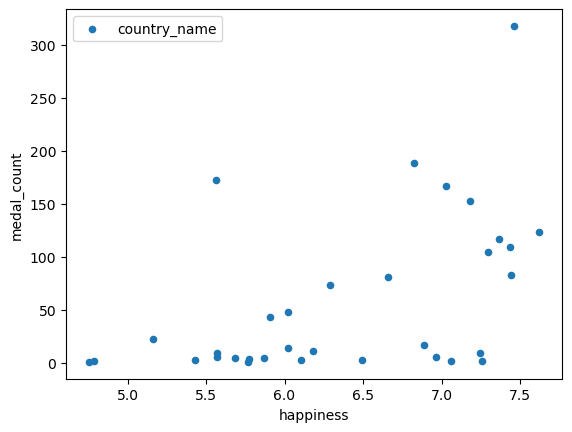

In [23]:
df.plot.scatter(x='happiness', y='medal_count', label='country_name')

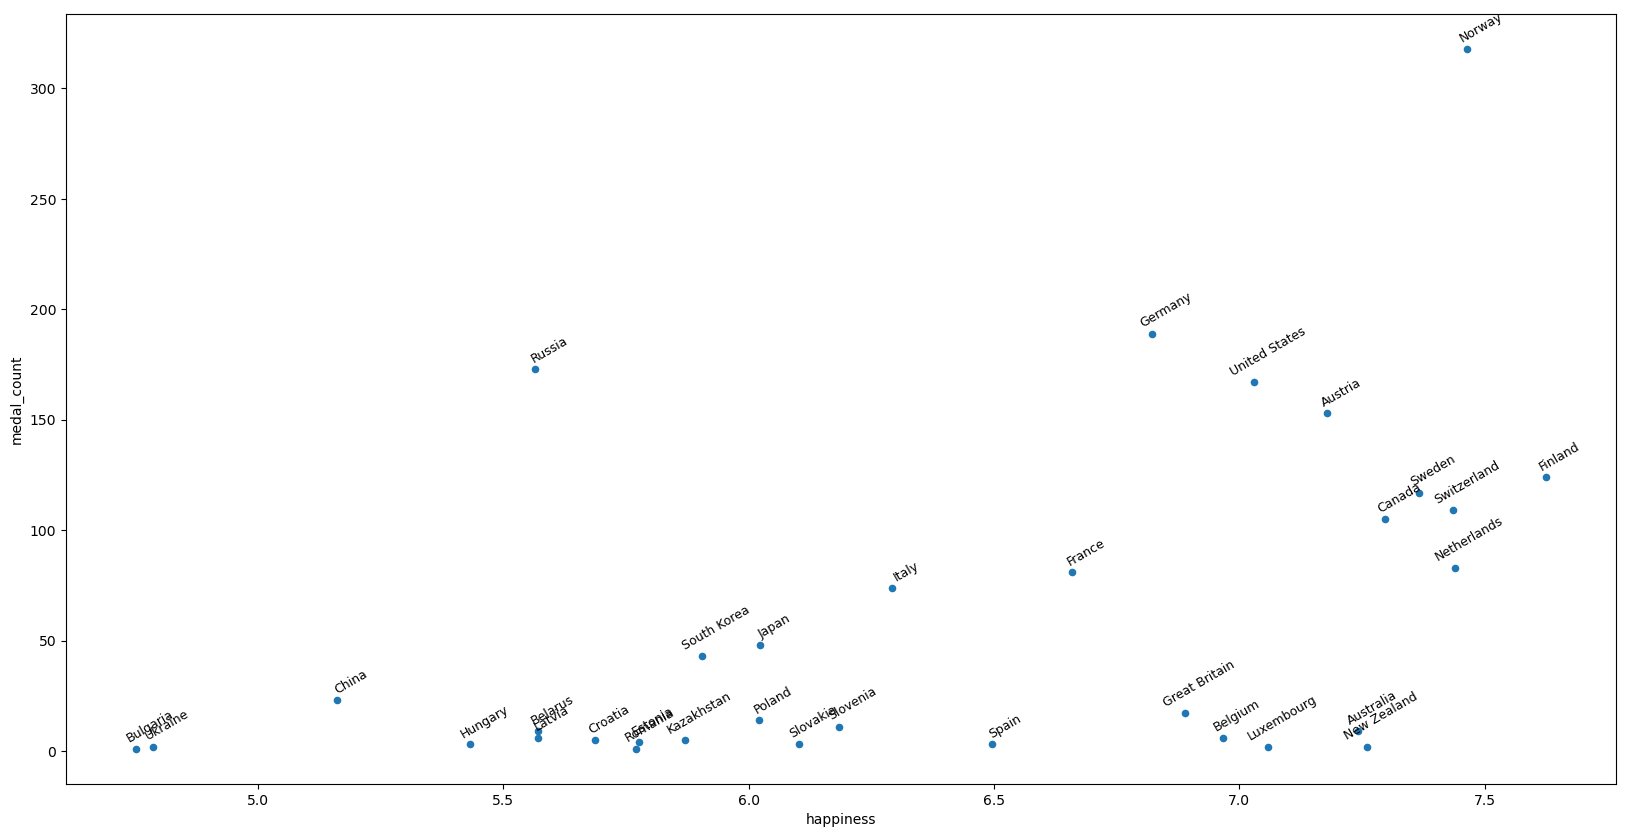

In [43]:
ax = df.plot(x='happiness', y='medal_count', kind='scatter', figsize=(20, 10))
for i, row in df.iterrows():
    ax.annotate(row['country_name'], (row['happiness'], row['medal_count']), rotation=30, fontsize=9, textcoords="offset points", xytext=(10,5), ha='center')
plt.show()

In [44]:
df_medal_details

,game_season,country_code,country_name,discipline_title,event_title,event_gender,medal_type,medal_count
0,Summer,AFG,Afghanistan,Taekwondo,58 - 68 kg men,Men,BRONZE,1
1,Summer,AFG,Afghanistan,Taekwondo,beijing 2008 taekwondo - 58 kg men,Men,BRONZE,1
2,Summer,AHO,Netherlands Antilles,Sailing,division ii - windsurfer men,Open,SILVER,1
3,Summer,ALG,Algeria,Athletics,1500m men,Men,GOLD,2
4,Summer,ALG,Algeria,Athletics,1500m men,Men,SILVER,1
...,...,...,...,...,...,...,...,...
13125,Winter,UZB,Uzbekistan,Freestyle Skiing,aerials women,Women,GOLD,1
13126,Winter,YUG,Yugoslavia,Alpine Skiing,giant slalom men,Men,SILVER,1
13127,Winter,YUG,Yugoslavia,Alpine Skiing,slalom women,Women,SILVER,1
13128,Winter,YUG,Yugoslavia,Ski Jumping,large hill individual men,Men,BRONZE,1


In [47]:
df_medal_counts = df_medal_details.groupby('country_name')['medal_count'].sum().reset_index()
df_medal_counts


,country_name,medal_count
0,Afghanistan,2
1,Algeria,17
2,Argentina,77
3,Armenia,18
4,Australasia,12
...,...,...
143,"Virgin Islands, US",1
144,West Indies Federation,2
145,Yugoslavia,87
146,Zambia,2


In [48]:
df_country_details = pd.read_csv('../data/etl/merged_medal_hap_nut_gdp_by_country.csv')

In [51]:
df_country_details
S
# Duplicative Czech Republic with differing medal counts
# Not alphabetically sorted
# Korea North and South separated
# "MIX" has 23 medals but unknown what it actually is (mixed team designation)
# "Unified team" hs 135 medals
# West Indies Federation and Yugoslavia do not exist anymore and therefore cannot be reconciled with the comparative data

,country_name,medal_count,happiness,wealth,support,health,freedom,generosity,corruption,positivity,negativity,calories_pct,nutrients_pct,good_diet_pct,bad_diet_pct,calories_mills,nutrients_mills,diet_mills,population,gdp_avg
0,Afghanistan,2,3.219917,7.585624,0.476654,52.711667,0.480475,0.056325,0.835824,0.421804,0.370840,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13093.44
1,Netherlands Antilles,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Algeria,17,5.391880,9.338236,0.811683,66.136363,0.520711,-0.132543,0.688052,0.540448,0.266245,0.2,7.2,64.8,35.2,0.1,3.0,14.6,41389.174,79710.57
3,Australasia,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Argentina,77,6.289722,10.028808,0.901894,66.700000,0.777786,-0.153203,0.839019,0.737995,0.288382,0.3,7.1,89.0,11.0,0.1,3.1,4.8,44044.811,317986.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,Vietnam,4,5.437579,8.977185,0.827434,64.900000,0.898700,-0.024657,0.771082,0.623233,0.204675,1.3,15.9,67.6,32.4,1.2,15.1,30.7,94600.643,NaN
150,West Indies Federation,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
151,Yugoslavia,87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
152,Zambia,2,4.365957,8.058288,0.725218,52.047059,0.774665,0.020810,0.821056,0.676104,0.302208,63.8,81.8,12.4,87.6,10.7,13.8,14.8,16853.608,8339.74
